## Demonstration of Selected Frequency-Domain Features

This jupyter notebook is part of a [collection of notebooks](../index.ipynb) on various topics of Digital Signal Processing. Please direct questions and suggestions to [Sascha.Spors@uni-rostock.de](mailto:Sascha.Spors@uni-rostock.de).

This notebook demonstrates the computation and usage of various frequency-domain features. The audio and music processing toolkit [`librosa`](https://librosa.org/) is used to calculate and visualize some of the features. For illustration of the features, two different signals are considered a

1. harmonic signal, and a
2. speech signal.

Both signals are segmented for the time-frequency features.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

segment_length = 2048  # length of segments in samples
hop_size = 512  # hop size in samples

In [2]:
def segments(signal, segment_length=32, hop_size=16, window=None):
    '''Split signal into overlapping windowed segments.'''

    # split signal into segments
    segments = librosa.util.frame(
        signal, frame_length=segment_length, hop_length=hop_size)
    # window segments
    if window is not None:
        segments = window(segment_length).reshape(1, -1) * segments.T

    return np.array(segments)

Load and segment speech signal

In [3]:
speech, fs = librosa.load('../data/speech_8k.wav', sr=None)
speech_segments = segments(
    speech, segment_length=segment_length, hop_size=hop_size, window=np.hamming)

Generate and segment harmonic signal. The harmonic signal is composed from a superposition of a sine signal with a frequency of $f_0 = 440$ Hz and four harmonics with multiples of $f_0$.

In [4]:
t = np.arange(len(speech)) / fs
fundamental = 440.0
f = np.arange(1, 6) * fundamental
harmonics = np.sin(2.0*np.pi*f[:, None]*t).sum(axis=0)

harmonics_segments = segments(
    harmonics, segment_length=segment_length, hop_size=hop_size, window=np.hamming)

### Discrete Fourier Transform of Real-Valued Signals

The [discrete Fourier transform](https://en.wikipedia.org/wiki/Discrete_Fourier_transform) (DFT) of a real-valued signal exhibits [specific symmetries](https://en.wikipedia.org/wiki/Discrete_Fourier_transform#Real_and_imaginary_part). These may for instance be exploited in the DFT of real-valued signals (RDFT) in order to lower the computational complexity of the transform. In machine learning these symmetries would result in redundant entries in the feature vector, which in many cases is not desired. In the following, the DFT and the RDFT of a real-valued signal are compared. First the standard DFT of one segment of the harmonic signal is computed using the fast Fourier transform [`numpy.fft.fft`](https://numpy.org/doc/stable/reference/generated/numpy.fft.fft.html) and the magnitude spectrum is plotted. Please observe the symmetries in the magnitude spectrum.

In [5]:
def plot_spectrum(X):    
    plt.plot(np.abs(X))
    plt.xlabel(r'$\mu$')
    plt.ylabel(r'$|X[\mu]|$')
    plt.grid()

Dimension of the feature vector: (2048,)


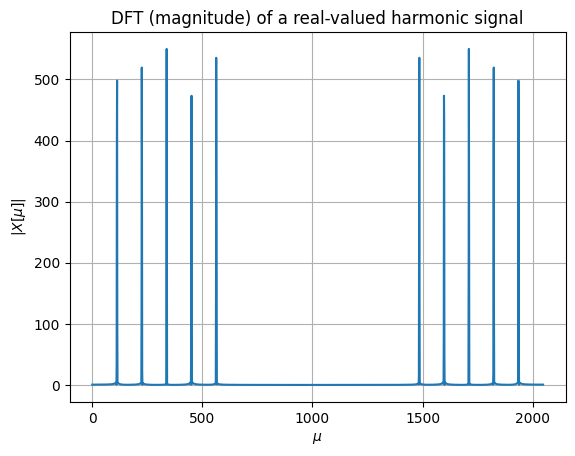

In [6]:
X = np.fft.fft(harmonics_segments[0,:])

plot_spectrum(X)
plt.title('DFT (magnitude) of a real-valued harmonic signal')

print('Dimension of the feature vector: {}'.format(X.shape))

Now the RDFT of the real-valued harmonic signal is computed using [`numpy.fft.rfft`](https://numpy.org/doc/stable/reference/generated/numpy.fft.rfft.html). Compare the result to above spectrum and compare the resulting lengths of the feature vectors.

Dimension of the feature vector: (1025,)


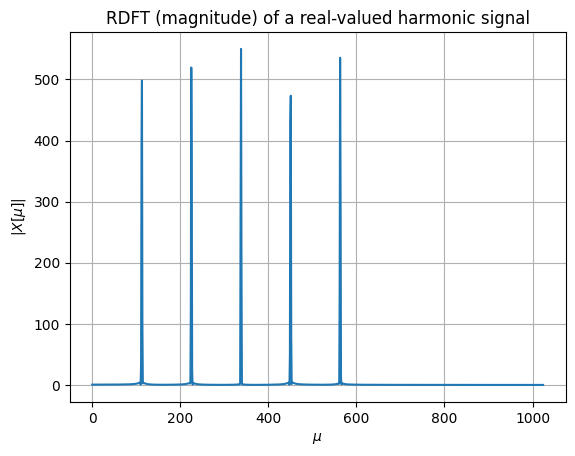

In [7]:
X = np.fft.rfft(harmonics_segments[0,:])

plot_spectrum(X)
plt.title('RDFT (magnitude) of a real-valued harmonic signal')

print('Dimension of the feature vector: {}'.format(X.shape))

As final example, the magnitude spectrum of one segment of the speech signal is computed and plotted using the RDFT.

Text(0.5, 1.0, 'RDFT (magnitude) of a speech segment')

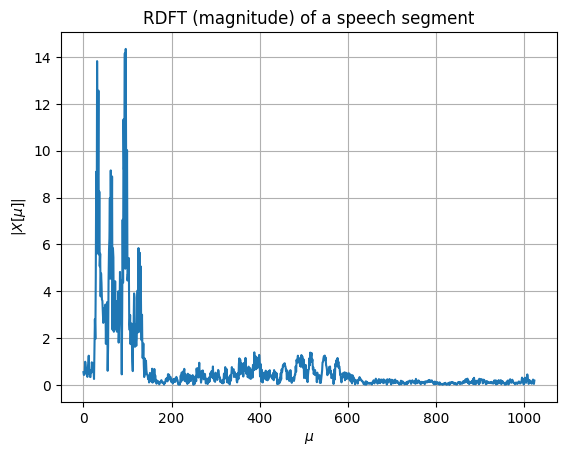

In [8]:
X = np.fft.rfft(speech_segments[20,:])

plot_spectrum(X)
plt.title('RDFT (magnitude) of a speech segment')

### Cepstrum

The cepstrum, as alternative to the magnitude spectrum, is illustrated in the following. First functions are defined which compute and plot the cepstrum.

In [9]:
def cepstrum(x, fs):

    X = np.fft.rfft(x)
    Cx = np.fft.irfft(np.log(np.abs(X)))

    f = np.fft.rfftfreq(len(x), 1/fs)
    df = f[1] - f[0]
    quefrency = np.fft.rfftfreq(Cx.size, df)
    N = len(quefrency)

    return quefrency, Cx[:N]


def plot_cepstrum(quefrency, Cx):

    plt.plot(quefrency, np.abs(Cx))
    plt.xlabel(r'quefrency in seconds')
    plt.ylabel(r'cepstrum (magnitude)')
    plt.grid()

The magnitude cepstrum of one segment of the harmonic signal is computed and plotted.

(0.0, 0.5)

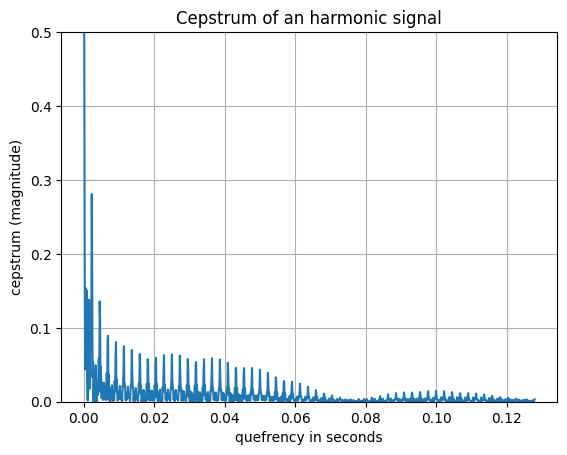

In [10]:
quefrency, Cx = cepstrum(harmonics_segments[0,:], fs)

plot_cepstrum(quefrency, Cx)
plt.title('Cepstrum of an harmonic signal')
plt.ylim([0, 0.5])

The magnitude cepstrum of one segment of the speech signal is computed and plotted.

(0.0, 0.5)

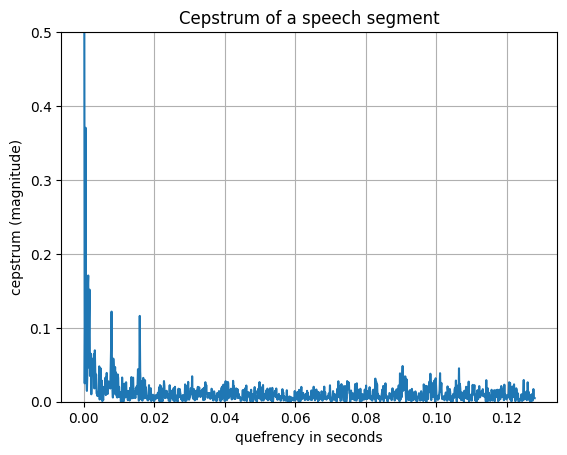

In [11]:
quefrency, Cx = cepstrum(speech_segments[20,:], fs)

plot_cepstrum(quefrency, Cx)
plt.title('Cepstrum of a speech segment')
plt.ylim([0, 0.5])

Instead of computing the cepstrum for one segment only we can computed and plot the cepstrum for all segments of the speech signal

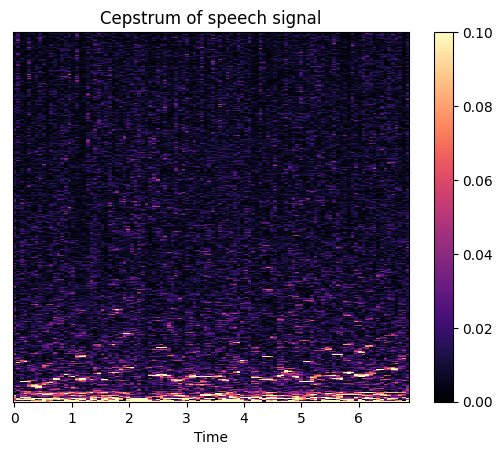

In [12]:
Cx = []
for segment in speech_segments:
    _, Cxi = cepstrum(segment, fs)
    Cx.append(Cxi)
Cx = np.array(Cx)
    
fig, ax = plt.subplots()
img = librosa.display.specshow(np.abs(Cx.T), hop_length=hop_size, sr=fs,  x_axis='time', ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title='Cepstrum of speech signal')
img.set_clim([0, 0.1])

### Spectrogram

The spectrogram is composed from the magnitude spectrum of the segments. In order to illustrate this feature, functions for its computation and plotting are defined first.

In [13]:
def specgram(segments):

    STFT = [np.fft.rfft(segment) for segment in segments]

    return np.array(np.abs(STFT))


def plot_specgram(S):

    fig, ax = plt.subplots()
    img = librosa.display.specshow(
        S.T, hop_length=hop_size, sr=fs,  x_axis='time', y_axis='linear', ax=ax)
    fig.colorbar(img, ax=ax)
    
    return img

Now the spectrogram of the harmonic signal is computed and plotted. Please observe the multiple harmonics the signal is composed of whose frequencies don't change over time.

Text(0.5, 1.0, 'Spectrogram of harmonic signal')

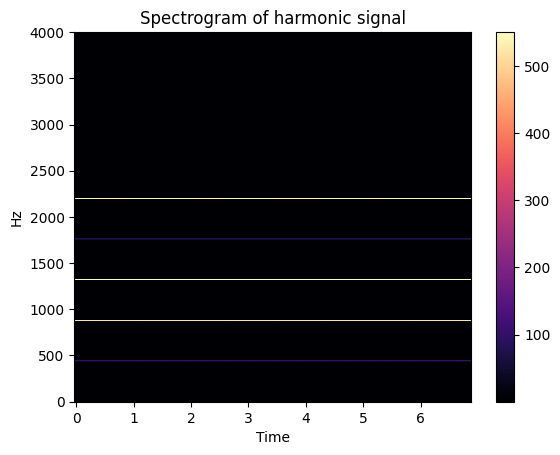

In [14]:
S = specgram(harmonics_segments)

plot_specgram(S)
plt.title('Spectrogram of harmonic signal')

The spectrogram of the speech signal is computed and plotted below.

Text(0.5, 1.0, 'Spectrogram of speech signal')

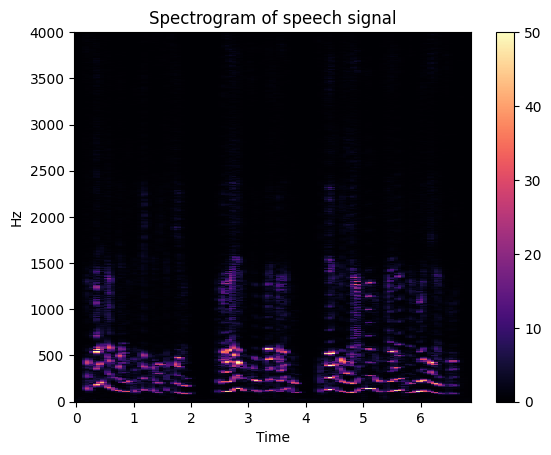

In [15]:
S = specgram(speech_segments)

img = plot_specgram(S)
img.set_clim([0, 50])
plt.title('Spectrogram of speech signal')

### Mel-Frequency Cepstral Coefficients

The mel-frequency cepstral coefficients (MFCCs) are frequently used in speech processing and recognition. We use the function [`librosa.feature.mfcc`](https://librosa.org/doc/main/generated/librosa.feature.mfcc.html) in order to compute this feature for the speech signal.

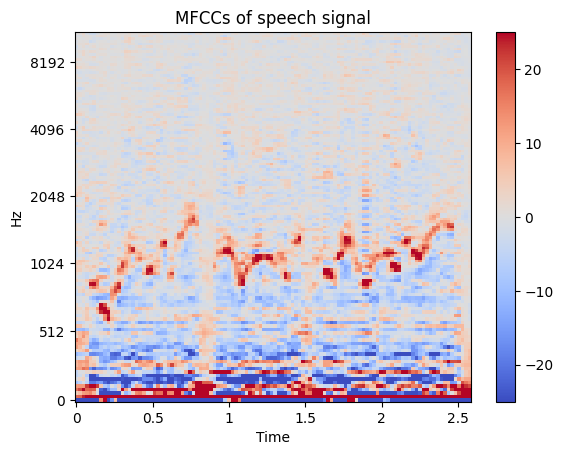

In [16]:
MFCC = librosa.feature.mfcc(y=speech, sr=fs, n_mfcc=128)


fig, ax = plt.subplots()
img = librosa.display.specshow(MFCC, x_axis='time', y_axis='mel', ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title='MFCCs of speech signal')
img.set_clim([-25, 25])

**Copyright**

This notebook is provided as [Open Educational Resource](https://de.wikipedia.org/wiki/Open_Educational_Resources).
The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/)
, the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT). Please attribute the work as follows: Sascha Spors, Data driven audio signal processing - Lecture supplementals.